<a href="https://colab.research.google.com/github/Galeano-Garcia-GS/Synergistic-SCFA-production-by-Fiber-Mixture/blob/main/q2_SCNIC_co_ocurrence_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# q2-SCNIC

- You can hide all the code below by clicking on the little arrow pointing down.

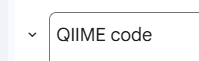

In [ ]:
#@title ## QIIME code

user = "ggaleano"  #@param {type:"string"}
qiime_working_directory = "/scratch/bell/ggaleano/coocurrence/family_level/Propionate_synergy/No_synergy/"  #@param {type:"string"}
imput_files_location = "/scratch/bell/ggaleano/coocurrence/family_level/"  #@param {type:"string"}
# @markdown - Imput your feature table and metadata here ⬆️
# @markdown - Example of [metadata](https://docs.google.com/spreadsheets/d/1-wPdeIyhaqFsRKwnbNOHMtiuoKm4dl8JYbpqTnPtUm8/edit?usp=sharing)
# @markdown - Example of [feature-table-mixture-family-level](https://drive.google.com/file/d/1w7VsHZo_xl2-GNlE-gPuZcGtxClNvtvy/view?usp=sharing)
filtering_formula = "[Propionate_synergy_category]='No_synergy'"  #@param {type:"string"}
correlation_method = "sparcc"  #@param ["spearman", "sparcc"]
p_val = 0.52  #@param {type:"slider", min:0.0, max:1.0, step:0.01}
# @markdown - Submit your output into Cytoscape.
correlation_metric = "r"  if correlation_method == "sparcc" else "p"
threshold = "min" if correlation_method == "sparcc" else "max"

method_clean = correlation_method.strip().lower()
is_sparcc = (method_clean == "sparcc")

sparcc_filter_block = (
    "# --- SparCC filter skipped for Spearman ---"
    if correlation_method == "spearman"
    else f"""qiime SCNIC sparcc-filter \\
  --i-table {qiime_working_directory}feature-table-filtered-low-abundances.qza \\
  --o-table-filtered {qiime_working_directory}feature-table-sparcc.qza"""
)

# Choose the correct input table for correlations/modules
table_for_corr = (
    f"{qiime_working_directory}feature-table-sparcc.qza"
    if correlation_method == "sparcc" else
    f"{qiime_working_directory}feature-table-filtered-low-abundances.qza"
)

print(
f'''
ssh {user}@bell.rcac.purdue.edu
cd {qiime_working_directory}

# --- Transfer Data ---
scp metadata.tsv {user}@bell.rcac.purdue.edu:{qiime_working_directory}
scp feature-table.tsv {user}@bell.rcac.purdue.edu:{qiime_working_directory}

# --- Environment Setup ---

squeue -A hamakerb
sinteractive -A hamakerb -p cpu -t 2:00:00 -n10

module --force purge
module load biocontainers qiime2
module list

# --- Setting up SCNIC ---

module --force purge
module load conda

# Create fresh environment for QIIME2 2024.10
wget https://data.qiime2.org/distro/amplicon/qiime2-amplicon-2024.10-py310-linux-conda.yml -O qiime2-amplicon.yml

conda env create -n qiime2-scnic --file qiime2-amplicon.yml
rm qiime2-amplicon.yml

# Activate environment
conda activate qiime2-scnic

# Install SCNIC (Python package) and QIIME2 plugin
pip install scnic==0.6.6
pip install git+https://github.com/lozuponelab/q2-SCNIC.git

# Register plugin
qiime dev refresh-cache

# Install FastSpar binary from Bioconda
conda install -c bioconda fastspar -y

# --- Convert and Import ---
biom convert \\
  -i {imput_files_location}feature-table.tsv \\
  --table-type="OTU table" \\
  --to-hdf5 \\
  -o {imput_files_location}feature-table.biom

qiime tools import \\
  --type 'FeatureTable[Frequency]' \\
  --input-format BIOMV210Format \\
  --input-path {imput_files_location}feature-table.biom \\
  --output-path {imput_files_location}feature-table.qza

# --- Filter samples by metadata ---
qiime feature-table filter-samples \\
  --i-table {imput_files_location}feature-table.qza \\
  --m-metadata-file {imput_files_location}metadata.tsv \\
  --p-where "{filtering_formula}" \\
  --o-filtered-table {qiime_working_directory}feature-table-filtered.qza

# --- Optional: remove low-abundance features ---
qiime feature-table filter-features \\
  --i-table {qiime_working_directory}feature-table-filtered.qza \\
  --p-min-frequency 10 \\
  --p-min-samples 2 \\
  --o-filtered-table {qiime_working_directory}feature-table-filtered-low-abundances.qza

# --- Run SCNIC Steps ---
{sparcc_filter_block}

# Correlations (use the correct table for the method)
qiime SCNIC calculate-correlations \\
  --i-table {table_for_corr} \\
  --p-method {correlation_method} \\
  --o-correlation-table {qiime_working_directory}correlations.qza

# Full network (pos + neg)
qiime SCNIC build-correlation-network-{correlation_metric} \\
  --i-correlation-table {qiime_working_directory}correlations.qza \\
  --p-{threshold}-val {p_val} \\
  --o-correlation-network {qiime_working_directory}Full_network_{filtering_formula}_{correlation_method}.qza

# Export full network to GML
qiime tools export \\
  --input-path {qiime_working_directory}Full_network_{filtering_formula}_{correlation_method}.qza \\
  --output-path {qiime_working_directory}network-exported-all-edges

# Download full network
scp -r {user}@bell.rcac.purdue.edu:{qiime_working_directory}network-exported-all-edges/network.gml .

# --- Module network (optional) ---
qiime SCNIC make-modules-on-correlations \\
  --i-correlation-table {qiime_working_directory}correlations.qza \\
  --i-feature-table {table_for_corr} \\
  --p-min-r 0.35 \\
  --o-collapsed-table {qiime_working_directory}collapsed.qza \\
  --o-correlation-network {qiime_working_directory}network-modules.qza \\
  --o-module-membership {qiime_working_directory}module-membership.qza

# Inspect module membership
qiime metadata tabulate \\
  --m-input-file {qiime_working_directory}module-membership.qza \\
  --o-visualization {qiime_working_directory}module-membership.qzv

# Export module-only network
qiime tools export \\
  --input-path {qiime_working_directory}network-modules.qza \\
  --output-path {qiime_working_directory}network-modules-export

# Download module network
scp -r {user}@bell.rcac.purdue.edu:{qiime_working_directory}network-modules-export/network.gml .

'''
)


ssh ggaleano@bell.rcac.purdue.edu
cd /scratch/bell/ggaleano/coocurrence/family_level/Propionate_synergy/No_synergy/

# --- Transfer Data ---
scp metadata.tsv ggaleano@bell.rcac.purdue.edu:/scratch/bell/ggaleano/coocurrence/family_level/Propionate_synergy/No_synergy/
scp feature-table.tsv ggaleano@bell.rcac.purdue.edu:/scratch/bell/ggaleano/coocurrence/family_level/Propionate_synergy/No_synergy/

# --- Environment Setup ---

squeue -A hamakerb
sinteractive -A hamakerb -p cpu -t 2:00:00 -n10

module --force purge
module load biocontainers qiime2
module list

# --- Setting up SCNIC ---

module --force purge
module load conda

# Create fresh environment for QIIME2 2024.10
wget https://data.qiime2.org/distro/amplicon/qiime2-amplicon-2024.10-py310-linux-conda.yml -O qiime2-amplicon.yml

conda env create -n qiime2-scnic --file qiime2-amplicon.yml
rm qiime2-amplicon.yml

# Activate environment
conda activate qiime2-scnic

# Install SCNIC (Python package) and QIIME2 plugin
pip install scnic==0